# Hyper-minimization of deterministic finite state automata

### Automata-lib

Here is the import of the automata-lib library. It is a Python library that provides a simple interface to work with deterministic finite state automata. It is used to create, manipulate, and visualize automata.

In [15]:
from automata.fa.dfa import DFA

### Practical example

Below is defined the original DFA on which the hyper minimization will be performed (example from [Hyper Minimization in O(n^2)](https://www.worldscientific.com/doi/abs/10.1142/S012905410900684X)):

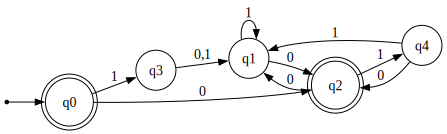

In [16]:
dfa = DFA(
  states={'q0', 'q1', 'q2', 'q3', 'q4'},
  input_symbols={'0', '1'},
  transitions={
    'q0': {'0': 'q2', '1': 'q3'},
    'q1': {'0': 'q2', '1': 'q1'},
    'q2': {'0': 'q1', '1': 'q4'},
    'q3': {'0': 'q1', '1': 'q1'},
    'q4': {'0': 'q2', '1': 'q1'}
  },
  initial_state='q0',
  final_states={'q2', 'q0'},
)
dfa

A brief look at the minimized (in the standard way) automaton:

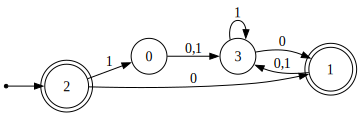

In [17]:
dfa.minify()

### Badr-Geffert-Shipman Algorithm 

#### Introduction

The first implemented algorithm is the one descrived in the [original paper](http://www.numdam.org/article/ITA_2009__43_1_69_0.pdf) regarding the hyper minimization of DFAs by Andrew Badr, Viliam Geffert and Ian Shipman.

This algorithm can be broken down in the following high-level steps:
- minimization (in the standard way i.e. using Hopcroft (preferred) or Brzozowski) of the input DFA
- identification of the states in the kernel and in the preamble
- collapse of the preamble states into other state in the same almost-equivalence class

More in detail, the algorithm works by performing a pre-processing to facilitate the operation of identifying the kernel states through the construction of a matrix $E$, the generic element $e_{i,j}$ is assigned as follows:

$$
\begin{equation*}
e_{i,j} =
  \begin{cases}
  1 \text{ if the state $q_j$ can be reached from the state $q_j$ with a path of length $> 0$} \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Next, builds a $K$ vector where the $i$-th element, corresponding to the $q_i$ state, is $1$ if the $i$-th state is in the kernel, $0$ otherwise, this task is accomplished by checking the elements of the matrix $E$, more precisely, the generic element $k_{i}$ is assigned as follows:

$$
\begin{equation*}
k_{i} =
  \begin{cases}
  1 \text{ if $e_{1,j} = e_{j,j} = e_{j, i} = 1$ } \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Finally, the algorithm calculates the almost-equivalence classes and collapses the preamble states into a kernel state if the almost-equivalence class contains both kernel and preamble states or collapses the preamble states into a non-kernel state if the almost-equivalence class contains only preamble states.

This last step is performed constructing a $P$ vector that associates to each state $q_i$ the set of the partition to which it belongs.

Initially, the partition is defined as follows: $P = \{ \{q_1\}, \{q_2\}, \dots, \{q_n\} \}$, then the algorithm iterates over the states and for each couple of states $q_i$ and $q_j$ checks if they are in the same almost-equivalence class, if they are, the algorithm merges the partitions to which they belong, mathematically, the almost-equivalence of two states not known to be almost-equivalent is checked as follows:

$$q_{i} \sim q_{j} \iff \forall \alpha \in \Sigma \quad \delta(q_{i}, \alpha), \delta(q_{j}, \alpha) \in Q_\alpha$$

#### Implementation

First of all, the `path_length` function is defined below, which calculates the length of the shortest path connecting two states within the automaton.

The function essentially performs a Breadth-First Search and requires $O(n \times m)$ time with $n$ the number of states of the automaton and $m$ the number of symbols in the alphabet accepted by the automaton.

In [18]:
def path_length(dfa: DFA, initial, target):
  """
  Calculate the length of the shortest path between two states in a DFA.
  If no path exists, return -1.
  """
  visited = set()
  queue = [{'state': initial, 'length': 0}]

  while queue:
    current = queue.pop(0)
    visited.add(current['state'])

    if current['state'] == target:
      return current['length']

    for state in dfa.transitions[current['state']].values():
      if state not in visited:
        queue.append({'state': state, 'length': current['length'] + 1})

  return -1

Next, the `bgs_hyper_minimize` function is defined, which implements the Badr-Geffert-Shipman algorithm, following the steps described above.

In [19]:
def bgs_hyper_minimize(dfa: DFA):
  """ 
  Hyper-minimize a DFA using the Badr-Geffert-Shipman algorithm.
  O(n^3 * m) time complexity, where n is the number of states and m is the number of input symbols.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = dfa.minify(retain_names=True)

  # Step 2 (pre-processing): analysis of the reachability in the transition graph (construction of the E matrix)
  E = [[path_length(minimal_dfa, x, y) > 0 for y in minimal_dfa.states] for x in minimal_dfa.states]

  # Step 3: kernel states identification

  # K[i] contains true if q_i is a kernel state, initially all states are considered as preamble states
  K = [False] * len(minimal_dfa.states)
  # iterate over the states to find the kernel states
  for i in range(len(minimal_dfa.states)):
    # condition to be a kernel state, refer to the paper for the explanation
    K[i] = any(E[0][j] and E[j][j] and E[j][i] for j in range(len(minimal_dfa.states)))

  # Step 4: almost-equivalence relation computation

  # initial partitioning of the states Q = {q_1} ∪ {q_2} ∪ ... ∪ {q_n}
  P = {i:i for i in minimal_dfa.states}
  # n-1 iterations needed to find all the almost-equivalence relations
  for _ in range(1, len(minimal_dfa.states)):
    # search for almost-equivalent states i.e. couples of states q_i1 and q_i2, with i1 ≠ i2, that
    # are not already in the same set of the partition P but are almost-equivalent
    for i_1 in minimal_dfa.states:
      for i_2 in minimal_dfa.states:
        if P[i_1] != P[i_2]:
          # check if the states are almost-equivalent
          almost_equivalent = True
          for symbol in minimal_dfa.input_symbols:
            next_q_i1 = minimal_dfa.transitions[i_1][symbol]
            next_q_i2 = minimal_dfa.transitions[i_2][symbol]

            if P[next_q_i1] != P[next_q_i2]:
              almost_equivalent = False
              break

          # if the states are almost-equivalent, merge the sets
          if almost_equivalent:
            P[i_2] = P[i_1]

  # Step 5: hyper-minimization of the DFA (useless states removal)
            
  # hyper-minimal DFA attributes initialization
  hyperminimal_states = set(minimal_dfa.states)                           # states
  hyperminimal_transitions = dict(minimal_dfa.transitions)                # transitions
  for key in hyperminimal_transitions.keys():                             # deep copy of the transitions
    hyperminimal_transitions[key] = dict(hyperminimal_transitions[key])   
  hyperminimal_initial_state = minimal_dfa.initial_state                  # initial state
  hyperminimal_final_states = set(minimal_dfa.final_states)               # final states

  # iterates over the sets of the partition
  for s in set(P.values()):

    # computes the preamble and kernel states of the current set of the partition
    kernels, preambles = [], []
    for i_r, r_i in enumerate(minimal_dfa.states):
      if P[r_i] == s: # state belongs to the current set
        if K[i_r]: # kernel state
          kernels.append(r_i)
        else: # preamble state
          preambles.append(r_i)

    # selects the state to which the preamble states will be redirected
    redirect_state = None
    if len(preambles) != 0: # if not, means that the set is composed only of kernel states so no state can be removed
      if len(kernels) != 0: # current set contains both preamble and kernel states
        redirect_state = kernels[0] # redirect state is a kernel state (arbitrary choice, first for semplicity)
      else:
        redirect_state = preambles[0] # redirect state is a preamble state (arbitrary choice, first for semplicity)
        preambles = preambles[1:] # remove the state from the preamble states list so it is not redirected to itself

    # removes the useless states
    for state in preambles:
      hyperminimal_states.remove(state)   # state is removed from the set of states
      del hyperminimal_transitions[state] # transitions from the state are removed

      # redirects the edges going into the removed state to the redirect state
      for hm_state in hyperminimal_states:
        for symbol in minimal_dfa.input_symbols:
          if hyperminimal_transitions[hm_state][symbol] == state:
            hyperminimal_transitions[hm_state][symbol] = redirect_state

      # finally, if the removed state was the initial state, the redirect state becomes the new initial state
      # and if the removed state was a final state, the redirect state becomes a final state and the removed state is
      # removed from the final states set
      if state == hyperminimal_initial_state:
        hyperminimal_initial_state = redirect_state
      if state in hyperminimal_final_states:
        hyperminimal_final_states.remove(state)
        hyperminimal_final_states.add(redirect_state)
  
  # creates and returns the hyper-minimal DFA
  return DFA(
    states=hyperminimal_states,
    input_symbols=set(minimal_dfa.input_symbols),
    transitions=hyperminimal_transitions,
    initial_state=hyperminimal_initial_state,
    final_states=hyperminimal_final_states
  )

The algorithm can be seen at work in the following cell.

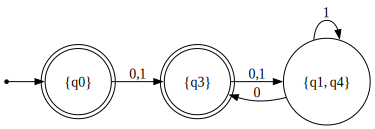

In [20]:
bgs_hyper_minimize(dfa)

#### Complexity

A brief note about the notation used in the following complexity analysis:
- $n$ is the number of states of the automaton
- $m$ is the number of symbols in the alphabet accepted by the automaton

The first step of the alorithm uses the Hopcroft minimization algorithm, which is well-known to have a time complexity of $O(n \times m)$.

The second step of the algorithm constructs the matrix $E$, which executes O(n^2) iterations, each of which requires $O(n \times m)$ time, thus the overall time complexity of this step is $O(n^3 \times m)$.

The third step of the algorithm constructs the vector $K$, which uses two nested loops, each of executes $O(n)$ iterations, thus the overall time complexity of this step is $O(n^2)$.

The fourth step of the algorithm constructs the vector $P$, which uses four nested loops, three of which execute $O(n)$ iterations and the last one executes $O(m)$ iterations, thus the overall time complexity of this step is $O(n^3 \times m)$.

The overall time complexity of the algorithm is $O(n^3 \times m)$.

### Badr Algorithm 

#### Introduction

The second implemented algorithm is the one described in [this paper](https://www.andrewbadr.com/files/hyper/ciaa32.pdf) by Andrew Badr.

This algorithm follows the same high-level steps as the previous one, but it differs in the way the almost-equivalence classes are calculated.

Following the paper, the algorithm is broken down in sub-functions each one performing a specific task (more details below):
- `xor_cross_product`
- `right finite states`
- `f_equivalence_classes`
- `f_merge_states`

#### Implementation

```xor_cross_product``` implements the XOR cross product of two automata.

More mathematically, the XOR cross product of two automata $D_1 = (Q_1, \Sigma, \delta_1, q_{I_1}, A_1)$ and $D_2 = (Q_2, \Sigma, \delta_2, q_{I_2}, A_2)$ is the automaton $D^\otimes$ such that $D^\otimes = (Q^\otimes, \Sigma, \delta^\otimes, q_I^\otimes, A^\otimes)$ where:
- $Q^\otimes = \{ (q_1, q_2) \space : \space q_1 \in Q_1 \space \wedge \space q_2 \in Q_2 \}$
- $\forall q_1 \in Q_1, \space \forall q_2 \in Q_2, \space \forall c \in \Sigma \space : \space \delta^\otimes((q_1, q_2), c) = (\delta_1(q_1, c), \delta_2(q_2, c))$
- $q_I^\otimes = (q_{I_1}, q_{I_2})$
- $A^\otimes = \{ (q_1, q_2) \space : \space (q_1 \in A_1) \space \otimes \space (q_2 \in A_2) \}$

In [21]:
def xor_cross_product(dfa_1: DFA, dfa_2: DFA):
  """
  Computes the cross product between two DFAs.
  """
  # computes the states set of the cross product DFA
  states = set()
  for q_1 in dfa_1.states:
    for q_2 in dfa_2.states:
      states.add((q_1, q_2))

  # computes the transitions of the cross product DFA
  transitions = dict()
  for q_1 in dfa_1.states:
    for q_2 in dfa_2.states:
      transitions[(q_1, q_2)] = dict()
      for symbol in dfa_1.input_symbols:
        transitions[(q_1, q_2)][symbol] = (dfa_1.transitions[q_1][symbol], dfa_2.transitions[q_2][symbol])

  # computes the final states of the cross product DFA
  finals = set()
  for q in states:
    if q[0] in dfa_1.final_states and q[1] not in dfa_2.final_states:
      finals.add(q)
    elif q[0] not in dfa_1.final_states and q[1] in dfa_2.final_states:
      finals.add(q)
  
  # creates and returns the cross product DFA
  return DFA(
    states=states,
    input_symbols=set(dfa_1.input_symbols),
    transitions=transitions,
    initial_state=(dfa_1.initial_state, dfa_2.initial_state),
    final_states=finals
  )

A rapid look at the implementation of the XOR cross product function reveals that:
- $Q^\otimes$ is computed in time $O(n^2)$
- $\delta^\otimes$ is computed in time $O(n^2 \times m)$
- $A^\otimes$ is computed in time $O(n^2)$

Since the cardinality of the alphabet is not relevant in the complexity analysis, the overall time complexity of the XOR cross product function is $O(n^2)$.

```right_finite_state``` computes the subset $F \subset Q$ of all states that induce a finite language of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

Note that the function not only requires the automaton $D$ as input, but also the set $S$ of all states in $Q$ that induce the empty language, more precisely, $S = \{ q \in Q \space : \space \forall w \in \Sigma^* \space : \space \delta(q, w) \notin A \}$.

In [22]:
def right_finite_state(dfa: DFA, S: set):
  """
  Computes the subset F of Q of all states of the DFA that induce a finite language.
  """
  # computes S' = Q \ S
  S_prime = {q for q in dfa.states if q not in S}

  # initializes the incoming and outgoing edges sets for each state
  incoming, outgoing = dict(), dict()
  for q in dfa.states:
    incoming[q] = set()
    outgoing[q] = set()

  # computes the incoming and outgoing edges for each state in S'
  for q in S_prime:
    for c in dfa.input_symbols:
      q_prime = dfa.transitions[q][c]
      incoming[q_prime].add((q, c))
      outgoing[q].add((q_prime, c))

  # computes the subset F of Q of all states that induce a finite language
  F = list()
  to_process = list(S)
  while to_process:
    q = to_process.pop(0)
    F.append(q)
    
    for q_prime, c in incoming[q]:
      outgoing[q_prime].remove((q, c))
      if not outgoing[q_prime]:
        to_process.append(q_prime)

  return F

Again, a rapid look at the implementation of the XOR cross product function reveals that:
- $S'$ is computed in time $O(n)$
- $incoming$ and $outgoing$ initialization requires time $O(n)$ and are next populated in time $O(n \times m)$
- $F$ is computed in time $O(n \times m)$

The next implementations need a QuickUnion data structure, which is implemented below, more precisely, the `QuickUnion` class which solves the famous same-name problem.

Since this is a side problem, the implementation is a slighty modified version of the one found [here](https://gist.github.com/ClaireLee22/628327455639bdec4b86ec13a4db996f#file-union_find-py), thanks to [ClaireLee22](https://gist.github.com/ClaireLee22).

In [36]:
class QuickUnion:
  def __init__(self):
    """
    Initializes an empty partition.
    """
    # parent[q_i] contains the name of the set to which q_i belongs
    self.parent = dict()
    # rank[q_i] contains the rank of the set to which q_i belongs
    self.rank = dict()
    # sets[q_i] contains the elements of the set which name is q_i
    self.sets = dict()
  
  def make_set(self, q):
    """
    Creates and adds a new singleton set containing object x which name is x.

    Parameters:
      q: The object to be added to the partition.
    """
    self.parent[q] = q
    self.rank[q] = 0
    self.sets[q] = {q}

  def find(self, x):
    """
    Finds and returns the 

    Parameters:
      x: The object whose set is to be found.

    Returns:
      The name of the set to which object x belongs, or None if x is not in the partition.
    """
    if x not in self.parent:
      return None
        
    # path compression
    if x != self.parent[x]:
      self.parent[x] = self.find(self.parent[x])
      
    return self.parent[x]
  
  def union(self, x, y):
    """
    Merges the trees containing objects x and y using union-by-rank.

    Parameters:
      x: The first object whose set is to be merged.
      y: The second object whose set is to be merged.
    """
    root_x = self.find(x)
    root_y = self.find(y)

    if root_x is None or root_y is None:
      return
    
    if root_x != root_y:
      rank_increment = 1 if self.rank[root_x] == self.rank[root_y] else 0

      if self.rank[root_x] > self.rank[root_y]:
        root_x, root_y = root_y, root_x

      self.parent[root_y] = root_x
      self.sets[root_x].update(self.sets[root_y])
      del self.sets[root_y]
      self.rank[root_x] += rank_increment

  def partition(self):
    """
    Returns the partition represented by the instance.

    Returns:
      A list of sets, each containing the elements of a set in the partition.
    """
    return list(self.sets.values())

```f_equivalence_classes``` computes the almost-equivalence classes of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

In [37]:
def f_equivalence_classes(dfa: DFA):
  """ 
  Computes and returns a partition of the states of the DFA into the equivalnce-class determined by the f-equivalence relation.
  """
  # computes the cross-product of the DFA with itself
  D_xor = xor_cross_product(dfa, dfa)
  
  # computes the set S = {(q, q) | q ∈ Q} which is the set of all self-pair states in the cross-product
  S = set()
  for q in dfa.states:
    S.add((q, q))

  # computes the set of all states (q, r) in the cross-product such that (q, r) induces a finite language in the cross-product
  F = right_finite_state(D_xor, S)

  # computes the partition
  P = QuickUnion()
  for q in dfa.states:
    P.make_set(q)
  for q, r in F:
    P_q = P.find(q)
    P_r = P.find(r)
    if P_q != P_r:
      P.union(P_q, P_r)
  
  return P

```preamble_and_kernel``` computes the preamble and kernel states of an automaton $D = (Q, \Sigma, \delta, q_I, A)$.

In [38]:
def preamble_and_kernel(dfa: DFA):
  """
  Computes and returns the preamble set and the kernel set of states of the DFA.
  """
  # NOTE: a basic observation points out that all the function can be computes into a single for loop over the states
  # without storing each set saving memory and time complexity

  # initializes the kernel set
  K = set()

  for q in dfa.states:
    # initializes the set of states non trivially reachable from q_i
    R = set()

    # computes the set of states non trivially reachable from q_i
    for r in dfa.states:
      if path_length(dfa, q, r) > 0:
        R.add(r)
    
    # if q_i is a kernel state, add all the states non trivially reachable from q_i to the kernel set
    if q in R:
      K = K.union(R)

  return (set(dfa.states) - K, K)

```f_merge_states``` is the last step of the algorithm, returns a new automaton $D' = (Q', \Sigma, \delta', q_I', A')$ which is the hyper-minimized version of the input automaton $D = (Q, \Sigma, \delta, q_I, A)$.

$D'$ is constructed merging the preamble states into the kernel states if the almost-equivalence class contains both kernel and preamble states or merges the preamble states into a non-kernel state if the almost-equivalence class contains only preamble states.

In [42]:
def f_merge_states(dfa: DFA, E: QuickUnion, P: set, K: set):
  # hyper-minimal DFA attributes initialization
  hyperminimal_states = set(dfa.states)                           # states
  hyperminimal_transitions = dict(dfa.transitions)                # transitions
  for key in hyperminimal_transitions.keys():                     # deep copy of the transitions
    hyperminimal_transitions[key] = dict(hyperminimal_transitions[key])   
  hyperminimal_initial_state = dfa.initial_state                  # initial state
  hyperminimal_final_states = set(dfa.final_states)               # final states

  # iterates over the sets of the partition (almost-equivalence classes)
  for S in E.partition():

    # computes the preamble and kernel states of the current set of the partition
    P_S = S.intersection(P)
    K_S = S.intersection(K)

    # selects the state to which the preamble states will be redirected
    if K_S:
      R = K_S.pop()
    else:
      R = P_S.pop()

    # removes the useless states
    for q in P_S:
      # merge q into R
      hyperminimal_states.remove(q)   # state is removed from the set of states
      del hyperminimal_transitions[q] # transitions from the state are removed

      # redirects the edges going into the removed state to the redirect state
      for hm_state in hyperminimal_states:
        for symbol in dfa.input_symbols:
          if hyperminimal_transitions[hm_state][symbol] == q:
            hyperminimal_transitions[hm_state][symbol] = R

      # finally, if the removed state was the initial state, the redirect state becomes the new initial state
      # and if the removed state was a final state, the redirect state becomes a final state and the removed state is
      # removed from the final states set
      if q == hyperminimal_initial_state:
        hyperminimal_initial_state = R
      if q in hyperminimal_final_states:
        hyperminimal_final_states.remove(q)
        hyperminimal_final_states.add(R)

  # creates and returns the hyper-minimal DFA
  return DFA(
    states=hyperminimal_states,
    input_symbols=dfa.input_symbols,
    transitions=hyperminimal_transitions,
    initial_state=hyperminimal_initial_state,
    final_states=hyperminimal_final_states
  )

Grouping all the functions together, the Badr algorithm is implemented in the `badr_hyper_minimize` function.

In [43]:
def badr_hyper_minimize(dfa):
  """
  Hyper-minimize a DFA using the Badr algorithm.
  O(n^2) time complexity, where n is the number of states.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = dfa.minify(retain_names=True)

  # Step 2: equivalence classes computation
  E = f_equivalence_classes(minimal_dfa)

  # Step 3: preamble and kernel states identification
  P, K = preamble_and_kernel(minimal_dfa)

  # Step 4: states merging
  return f_merge_states(minimal_dfa, E, P, K)

The algorithm can be seen at work in the following cell.

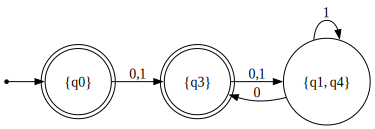

In [44]:
badr_hyper_minimize(dfa)

### Holzer-Maletti Algorithm

The last implemented algorithm, the one with the best time complexity, is the one described in [this paper](https://www.sciencedirect.com/science/article/pii/S030439751000321X) by Markus Holzer and Andreas Maletti.

Following the paper, some functions need to mutate the DFA object, sometimes leaving it in an inconsistent state, thus a mutable version of the DFA class is implemented.

In [6]:
class IncrementalDFA:
  def __init__(self, dfa: DFA):
    """
    Initialize an incremental DFA.
    """
    self.states = set(dfa.states)
    self.transitions = dict(dfa.transitions)
    self.initial_state = dfa.initial_state
    self.final_states = set(dfa.final_states)
    self.input_symbols = set(dfa.input_symbols)

  def delta(self, q, sigma):
    """
    Transition function of the DFA, just a little more theory-aligned notation.
    """
    return self.transitions[q][sigma]

  def build(self) -> DFA:
    """
    Build and return the DFA.
    """
    return DFA(
      states=self.states,
      input_symbols=self.input_symbols,
      transitions=self.transitions,
      initial_state=self.initial_state,
      final_states=self.final_states
    )
  

```merge``` function is used for merging a state $p$ into another state $q$ which means, redirecting all the incoming transitions of $p$ to $q$.

Formally, $merge(\delta, p_0, p, q) = (\delta', p_0')$ where for every $q' \in Q$ and $\sigma \in \Sigma$:

$$
\begin{equation*}
\delta'(q', \sigma) =
\begin{cases}
q \quad \text{if } \delta(q', \sigma) = p \\
\delta(q', \sigma) \quad \text{otherwise}
\end{cases}
\end{equation*}
$$

and

$$
\begin{equation*}
p'_0 =
\begin{cases}
q \quad \text{if } p_0 = p \\
p_0 \quad \text{otherwise}
\end{cases}
\end{equation*}
$$

In [7]:
def merge(dfa: DFA, p, q):
  delta_prime = dict()
  for q_prime in dfa.states:
    delta_prime[q_prime] = dict()
    for sigma in dfa.input_symbols:
      delta_prime[q_prime][sigma] = q if dfa.transitions[q_prime][sigma] == p else dfa.transitions[q_prime][sigma]

  return (delta_prime, q if dfa.initial_state == p else dfa.initial_state)

A slighty modified version of the Tarjan's algorithm is implemented in the `tarjan` function.

Classic Tarjan's algorithm is used to compute the strongly connected components of a graph, while the modified version calculates the center states of the automaton.

A state $q$ of the automaton $D = (Q, \Sigma, \delta, q_I , A)$ is a center state if it is in a strongly connected component of at least two states or $\exists \sigma \in \Sigma \space : \space \delta(q, \sigma) = q$.

In [8]:
def tarjan(dfa: DFA, q):
  """
  Using Tarjan's algorithm computes and returns the set of center states of the DFA.
  """
  center, index, low, S, i = set(), dict(), dict(), list(), 0

  def __tarjan(q):
    nonlocal center, index, low, S, i
    
    index[q], low[q], i = i, i, i + 1
    S.append(q)

    for sigma in dfa.input_symbols:
      if dfa.transitions[q][sigma] not in index:
        __tarjan(dfa.transitions[q][sigma])
        low[q] = min(low[q], low[dfa.transitions[q][sigma]])
      elif dfa.transitions[q][sigma] in S:
        low[q] = min(low[q], index[dfa.transitions[q][sigma]])

      if dfa.transitions[q][sigma] == q:
        center.add(q)

    if low[q] == index[q]:
      scc = set()
      while S[-1] != q:
        scc.add(S.pop())
      scc.add(S.pop())

      if len(scc) > 1:
        center = center.union(scc)
  
  for q in dfa.states:
    if q not in index:
      __tarjan(q)

  return center

Now the ```compute_kernel``` function is defined, it consists in executing a Depth-First Search from the center states of the automaton, obtained from the ```tarjan``` function, to find the kernel states.

In [9]:
def compute_kernel(dfa: DFA, q):
  center = tarjan(dfa, q)
  
  visited = set()
  reachable_states = set()

  def __depth_first_search(q):
    visited.add(q)
    reachable_states.add(q)

    for r in dfa.transitions[q].values():
      if r not in visited:
        __depth_first_search(r)

  for q in center:
    __depth_first_search(q)

  return center.union(reachable_states)

In [10]:
def almost_equivalent_states(dfa: IncrementalDFA):
  """
  Computes the almost-equivalent states of the DFA.
  """
  pi = {q:{q} for q in dfa.states} # partition

  h = dict()          # hash map
  I = list(dfa.states) # states to be processed
  P = set(dfa.states) # current states

  while I:
    q = I.pop(0) # pick a state q
    succ = tuple([dfa.delta(q, c) for c in dfa.input_symbols]) # vector of successors of q

    if succ in h:
      p = h[succ]

      if len(pi[p]) >= len(pi[q]):
        p, q = q, p
  
      P = P - {p}
      
      I.extend([r for r in P if p in dfa.transitions[r].values()])

      # merging
      dfa.transitions, dfa.initial_state = merge(dfa, p, q)
      
      pi[q] = pi[q].union(pi[p])

    h[succ] = q

  return pi.values()

In [11]:
def merge_states(dfa: IncrementalDFA, K: set, ae: set):
  for B in ae:
    intersection = B.intersection(K)
    if intersection:
      q = intersection.pop()
    else:
      q = B.pop()

    for p in B - K:
      dfa.transitions, dfa.initial_state = merge(dfa, p, q)
      dfa.states.remove(p)
      del dfa.transitions[p]
      if p in dfa.final_states:
        dfa.final_states.remove(p)

The main loop of the function iterates over the almost-equivalence classes which number is $O(n)$, 

In [12]:
def holzer_maletti_hyper_minimize(dfa: DFA):
  """
  Hyper-minimize a DFA using the Holzer-Maletti algorithm.
  O(n log n) time complexity, where n is the number of states.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = dfa.minify(retain_names=True)

  # Step 1.5: incremental DFA initialization
  hyper_minimal_dfa = IncrementalDFA(minimal_dfa)

  # Step 2: kernel states identification
  K = compute_kernel(minimal_dfa, minimal_dfa.initial_state)

  # Step 3: almost-equivalence relation computation
  ae = almost_equivalent_states(hyper_minimal_dfa)

  # Step 4: hyper-minimization of the DFA
  merge_states(hyper_minimal_dfa, K, ae)

  return hyper_minimal_dfa.build()

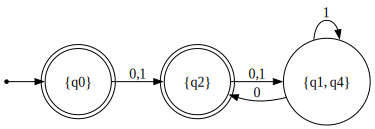

In [13]:
holzer_maletti_hyper_minimize(dfa)

### Proof of correctness

From the original paper: _an automaton $M$ is hyper-minimized if and only if, in $M$, $1$ there does not exist an unreachable state, $2$ there does not exist a pair of different but equivalent states, and $3$ there does not exist a pair of different but almost-equivalent states, such that at least one of them is a preamble state. (Two states are almost-equivalent if there exist at most finitely many input strings α such that, starting from these two states and reading α in parallel, we can reach a state pair with different acceptance values.) Note that the first two conditions alone characterize minimized automata._

Here is the algorithm which verify if a given automaton is hyper-minimized:

### Another example

Here is another, more extended, example of a DFA on which the hyper minimization will be performed (from Holzer-Maletti paper):

In [147]:
import timeit

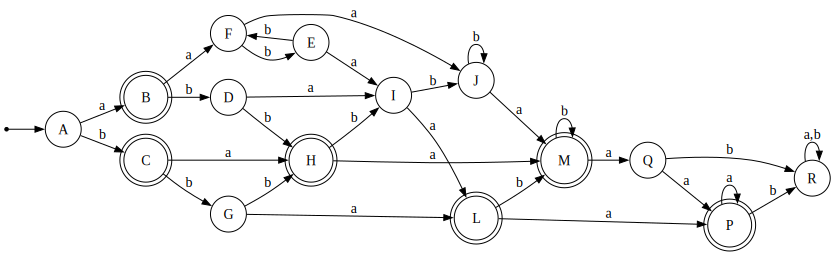

In [148]:
holzer_maletti_dfa = DFA(
  states={'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'P', 'Q', 'R'},
  input_symbols={'a', 'b'},
  initial_state='A',
  final_states={'B', 'C', 'H', 'M', 'L', 'P'},
  transitions={
    'A': {'a': 'B', 'b': 'C'},
    'B': {'a': 'F', 'b': 'D'},
    'C': {'a': 'H', 'b': 'G'},
    'D': {'a': 'I', 'b': 'H'},
    'E': {'a': 'I', 'b': 'F'},
    'F': {'a': 'J', 'b': 'E'},
    'G': {'a': 'L', 'b': 'H'},
    'H': {'a': 'M', 'b': 'I'},
    'I': {'a': 'L', 'b': 'J'},
    'J': {'a': 'M', 'b': 'J'},
    'L': {'a': 'P', 'b': 'M'},
    'M': {'a': 'Q', 'b': 'M'},
    'P': {'a': 'P', 'b': 'R'},
    'Q': {'a': 'P', 'b': 'R'},
    'R': {'a': 'R', 'b': 'R'}
  }
)
holzer_maletti_dfa

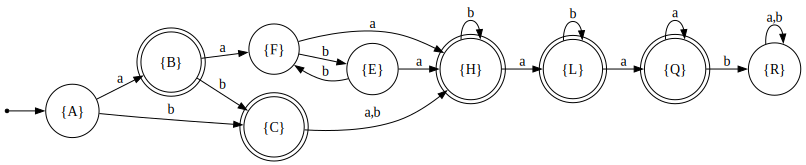

In [149]:
bgs_hyper_minimize(holzer_maletti_dfa)

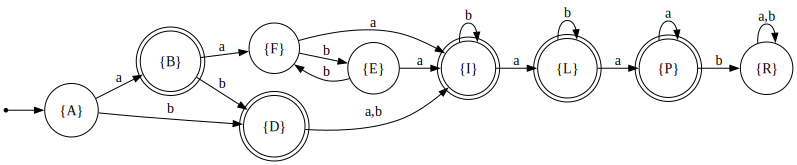

In [152]:
badr_hyper_minimize(holzer_maletti_dfa)

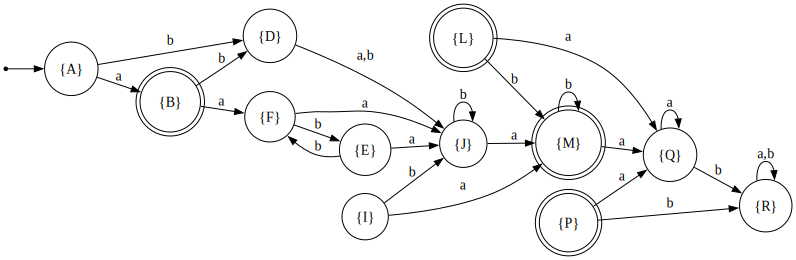

In [130]:
holzer_maletti_hyper_minimize(holzer_maletti_dfa)

In [101]:
badr_time = timeit.timeit(lambda: badr_hyper_minimize(holzer_maletti_dfa), number=100)
bgs_time = timeit.timeit(lambda: bgs_hyper_minimize(holzer_maletti_dfa), number=100)
hm_time = timeit.timeit(lambda: holzer_maletti_hyper_minimize(holzer_maletti_dfa), number=100)
print("Badr-Geffert-Shipman algorithm time:", bgs_time)
print("Badr algorithm time:", badr_time)
print("Holzer-Maletti algorithm time:", badr_time)

Badr-Geffert-Shipman algorithm time: 0.24272895799367689
Badr algorithm time: 0.30895062498166226
Holzer-Maletti algorithm time: 0.30895062498166226
